![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating



# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from datetime import datetime, timedelta
import re

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [6]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [7]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [8]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [10]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [11]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [13]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [15]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
39537,id_4664,Berlin,"['German', 'Fast Food']",4666.0,NaN,4.0,"[['Tasty sausage', 'Wider selection of Wursts'...",/Restaurant_Review-g187323-d12885121-Reviews-C...,d12885121,1,4.0
23659,id_5838,Barcelona,NaN,5839.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187497-d10042463-Reviews-L...,d10042463,1,4.0
271,id_271,Paris,NaN,8155.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187147-d13326576-Reviews-G...,d13326576,0,0.0
15906,id_2234,Lisbon,"['European', 'Portuguese', 'Seafood']",2237.0,$$ - $$$,68.0,"[['Typical for Lisbon', 'A Delicious Gem To Di...",/Restaurant_Review-g189158-d4091101-Reviews-O_...,d4091101,1,4.0
42219,id_427,Madrid,"['International', 'Fusion', 'Vegetarian Friend...",428.0,$$ - $$$,190.0,"[['Very good food and wine !', 'Great food in ...",/Restaurant_Review-g187514-d2320681-Reviews-Ca...,d2320681,1,4.0


In [16]:
data.Reviews[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   

In [17]:
#Посмотрим, в каких колонках и сколько пропусков

data.isnull().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64

In [18]:
# Далее заполняем пропуски нулем, делая предположения, что пропуск означает отсутствие отзывов

data['Number of Reviews'].fillna(0, inplace=True)

Два нулевых значения в колонке Reviews также заменяем нулем

In [19]:
data['Reviews'].fillna(0, inplace=True)

In [20]:
data.isnull().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews        0
Reviews                  0
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64

Оставшиеся две колонки с пустыми значениями обрабатываем ниже.

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [21]:
data.nunique(dropna=False)

Restaurant_id        13094
City                    31
Cuisine Style        10732
Ranking              12975
Price Range              4
Number of Reviews     1574
Reviews              41858
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
dtype: int64

**Price Range**

In [22]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3  

In [23]:
# Заменим значения на 1, 2 и 3

data['Price Range'] = data['Price Range'].apply(
    lambda x: 1 if x == '$' else 2 if x == '$$ - $$$' else 3 if x == '$$$$' else x)

In [24]:
data

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,2.0,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,2.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,2.0,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,3.0,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,3.0,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,Milan,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",500.0,2.0,79.0,"[['The real Italian experience!', 'Wonderful f...",/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5
49996,id_6340,Paris,"['French', 'American', 'Bar', 'European', 'Veg...",6341.0,2.0,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5
49997,id_1649,Stockholm,"['Japanese', 'Sushi']",1652.0,NaN,4.0,"[['Good by swedish standards', 'A hidden jewel...",/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5
49998,id_640,Warsaw,"['Polish', 'European', 'Eastern European', 'Ce...",641.0,2.0,70.0,"[['Underground restaurant', 'Oldest Restaurant...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0


In [25]:
#Заменим пропуски на моду по городам 

data['Price Range'] = data.groupby('City')['Price Range'].apply(lambda x: x.fillna(stats.mode(x)[0][0]))


Проверим, заполнили ли мы пустые значения

In [26]:
data.isnull().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range              0
Number of Reviews        0
Reviews                  0
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64

**Restaurant_id** и **URL_TA**

In [27]:
#Удалим эти колонки, так как они не несут никакой важной, на наш взгляд, информации

data.drop(['Restaurant_id', 'URL_TA'], axis = 1, inplace = True)

**Cuisine Style**

In [28]:
data['Cuisine Style']

0                                           ['Bar', 'Pub']
1        ['European', 'Scandinavian', 'Gluten Free Opti...
2                                  ['Vegetarian Friendly']
3        ['Italian', 'Mediterranean', 'European', 'Vege...
4        ['Italian', 'Mediterranean', 'European', 'Seaf...
                               ...                        
49995    ['Italian', 'Vegetarian Friendly', 'Vegan Opti...
49996    ['French', 'American', 'Bar', 'European', 'Veg...
49997                                ['Japanese', 'Sushi']
49998    ['Polish', 'European', 'Eastern European', 'Ce...
49999                                          ['Spanish']
Name: Cuisine Style, Length: 50000, dtype: object

Как мы видим, нужно удалить скобки и ковычки, разделить виды кухонь, а также создать дополнительный столбец с количеством кухонь в одном ресторане. Сделаем предположение, что пропуск означает 1 кухню (может, это ресторан опреденной кухни).

In [29]:
data['Cuisine Style'].fillna('[]', inplace=True)

data['Cuisine Style'] = data['Cuisine Style'].apply(
    lambda x: str(x).replace('[', '').replace(']', '').replace("'", '').replace(' ', '').replace('"', ''))

data['Cuisine Style'] = data['Cuisine Style'].apply(lambda x: x.split(','))

data['Number of Cuisine Styles'] = data['Cuisine Style'].apply(lambda x: len(x))

Опять проверим

In [30]:
data.isnull().sum()

City                        0
Cuisine Style               0
Ranking                     0
Price Range                 0
Number of Reviews           0
Reviews                     0
ID_TA                       0
sample                      0
Rating                      0
Number of Cuisine Styles    0
dtype: int64

**Ranking**

Нормируем по городам

In [31]:
data['Ranking'] = data.groupby('City')['Ranking'].apply(lambda x: x/x.max())



**Reviews**

In [32]:
data['Reviews']


0                                                 [[], []]
1        [['Very good reviews!', 'Fine dining in Hakani...
2        [['Better than the Links', 'Ivy Black'], ['12/...
3        [['Most exquisite', 'Delicious and authentic']...
4        [['Always the best in bratislava', 'Very good ...
                               ...                        
49995    [['The real Italian experience!', 'Wonderful f...
49996    [['Parisian atmosphere', 'Bit pricey but inter...
49997    [['Good by swedish standards', 'A hidden jewel...
49998    [['Underground restaurant', 'Oldest Restaurant...
49999    [['Average', 'Nice an informal'], ['01/31/2016...
Name: Reviews, Length: 50000, dtype: object

Нужно будет привести эту колонку в более удобный формат

In [33]:
data['Reviews'] = data['Reviews'].apply(lambda x: str(x).replace('[',''))
data['Reviews'] = data['Reviews'].apply(lambda x: str(x).replace(']',''))
data['Reviews'] = data['Reviews'].apply(lambda x: str(x).replace(' ',''))

In [34]:
#создадим новый столбец date_of_Review

data['date_of_Review'] = data['Reviews'].str.findall('\d+/\d+/\d+')

data['date_of_Review']

0                              []
1        [12/05/2017, 10/29/2017]
2        [12/28/2017, 12/06/2017]
3        [12/06/2017, 11/22/2017]
4        [02/08/2018, 01/24/2018]
                   ...           
49995    [12/16/2017, 11/12/2017]
49996    [12/21/2017, 12/12/2017]
49997    [11/03/2016, 04/12/2008]
49998    [07/11/2017, 06/18/2017]
49999    [01/31/2016, 07/04/2012]
Name: date_of_Review, Length: 50000, dtype: object

Раделилим этот столбец на дату первого отзыва и дату последнего, затем создадим новую колонку с разницей между этими отзывами (в днях)

In [35]:
data['first_review'] = data['date_of_Review'].apply(lambda x: pd.to_datetime(x).min())



In [36]:
data['last_review'] = data['date_of_Review'].apply(lambda x: pd.to_datetime(x).max())

In [37]:
data['date_of_Review_difference'] = (data['last_review'] - data['first_review']).apply(lambda x: x.days)

Теперь заменим пропуски на округленное среднее значение

In [38]:
data['date_of_Review_difference'].fillna(round(data['date_of_Review_difference'].mean()), inplace=True)

In [39]:
#удалим first_review и last_review

data.drop(['first_review','last_review'], axis=1, inplace=True)

In [40]:
#One-Hot Encoding
#перенесем города в отдельные колонки

data['city'] = data['City'].copy()
data = pd.get_dummies(data, columns=[ 'city',], dummy_na=True)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

In [41]:
data['Ranking']

0        0.926855
1        0.092901
2        0.458664
3        0.101496
4        0.041620
           ...   
49995    0.079681
49996    0.453382
49997    0.670455
49998    0.297586
49999    0.769243
Name: Ranking, Length: 50000, dtype: float64

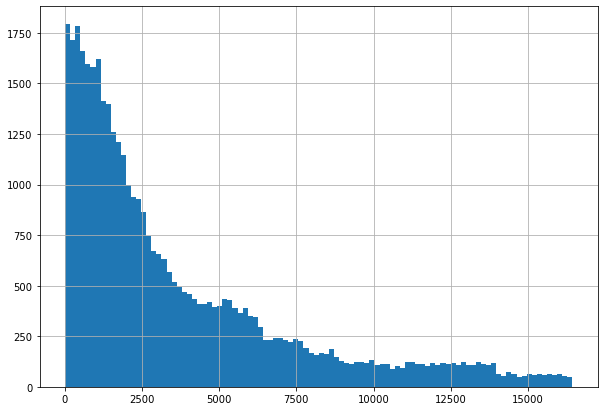

In [42]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

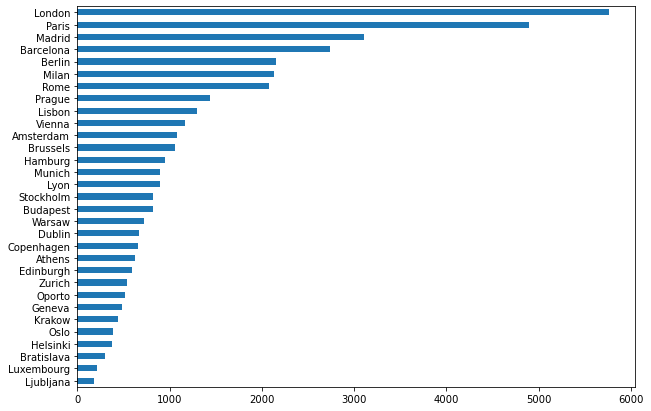

In [43]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

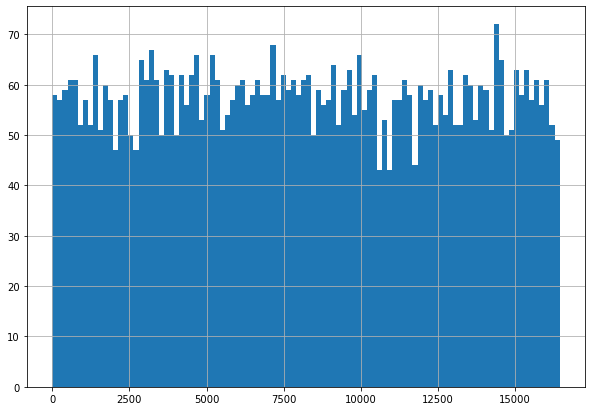

In [44]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

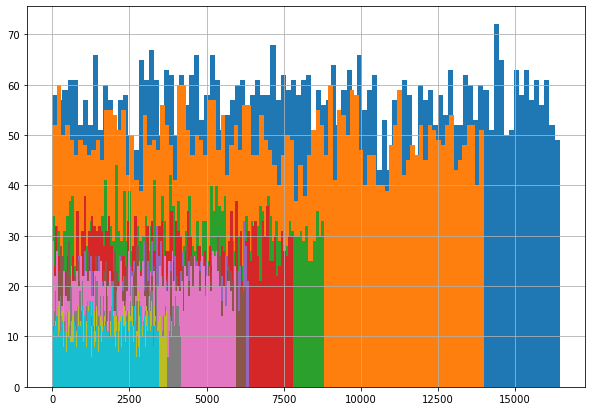

In [45]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

### Посмотрим распределение целевой переменной

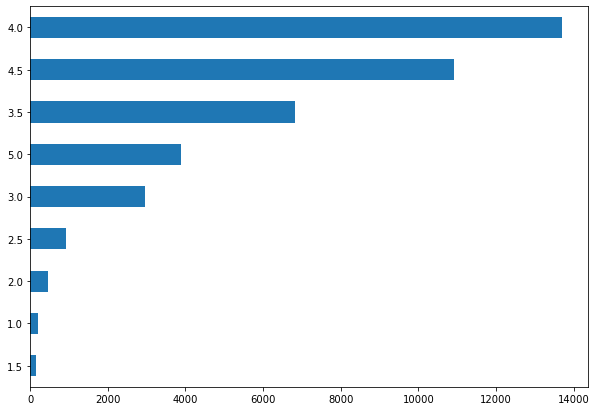

In [46]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

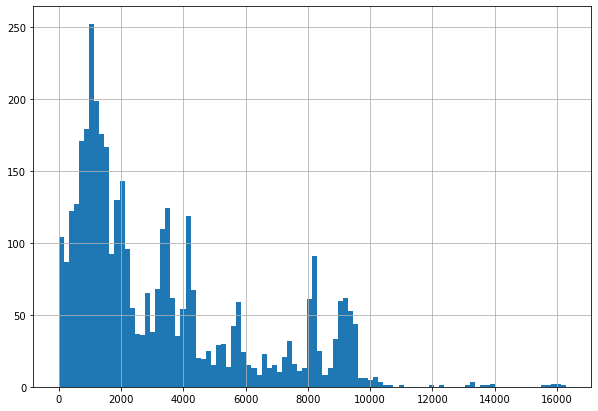

In [47]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

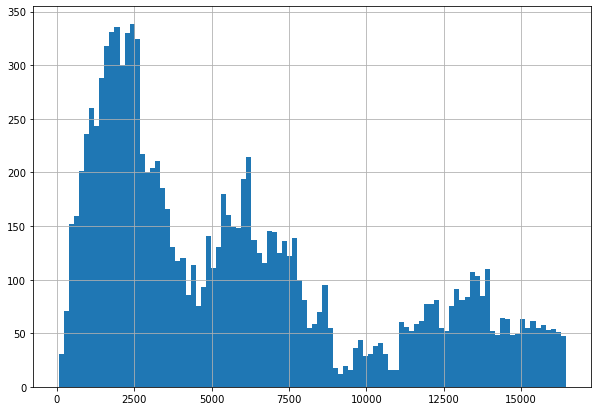

In [48]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

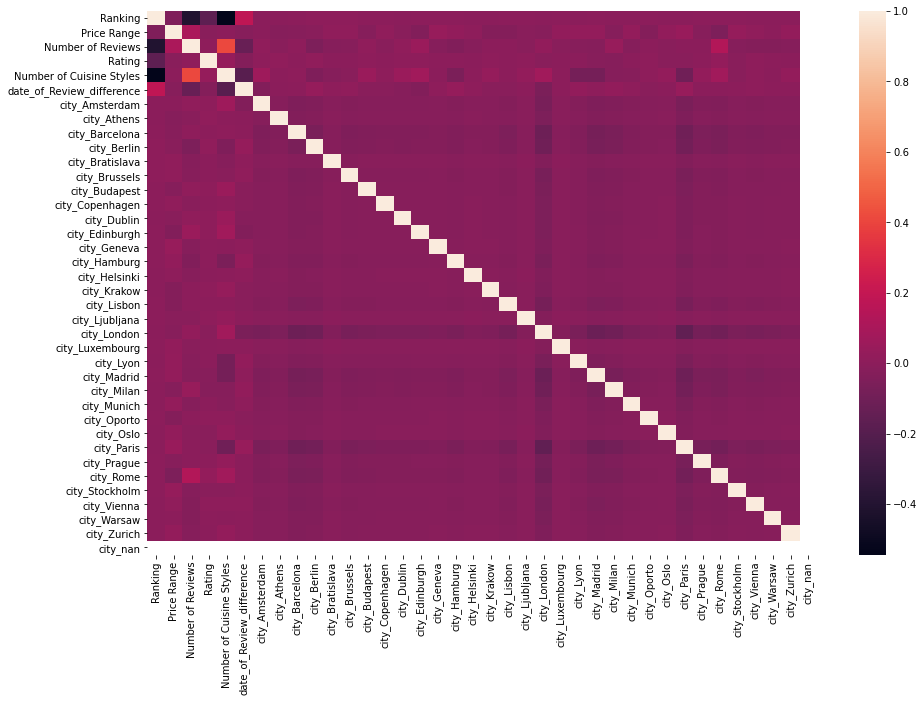

In [49]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

In [50]:
data

,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,ID_TA,sample,Rating,Number of Cuisine Styles,...,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,city_nan
0,Paris,"[Bar, Pub]",0.926855,2.0,4.0,",",d10746918,0,0.0,2,...,0,0,1,0,0,0,0,0,0,0
1,Helsinki,"[European, Scandinavian, GlutenFreeOptions, Ve...",0.092901,2.0,97.0,"'Verygoodreviews!','FinedininginHakaniemi','12...",d6674944,0,0.0,5,...,0,0,0,0,0,0,0,0,0,0
2,Edinburgh,[VegetarianFriendly],0.458664,2.0,28.0,"'BetterthantheLinks','IvyBlack','12/28/2017','...",d13129638,0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
3,London,"[Italian, Mediterranean, European, VegetarianF...",0.101496,3.0,202.0,"'Mostexquisite','Deliciousandauthentic','12/06...",d680417,0,0.0,5,...,0,0,0,0,0,0,0,0,0,0
4,Bratislava,"[Italian, Mediterranean, European, Seafood, Ve...",0.041620,3.0,162.0,"'Alwaysthebestinbratislava','Verygoodbutpricey...",d1112354,0,0.0,6,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,Milan,"[Italian, VegetarianFriendly, VeganOptions, Gl...",0.079681,2.0,79.0,"'TherealItalianexperience!','Wonderfulfood,won...",d2104414,1,4.5,4,...,0,0,0,0,0,0,0,0,0,0
49996,Paris,"[French, American, Bar, European, VegetarianFr...",0.453382,2.0,542.0,"'Parisianatmosphere','Bitpriceybutinterestingd...",d1800036,1,3.5,5,...,0,0,1,0,0,0,0,0,0,0
49997,Stockholm,"[Japanese, Sushi]",0.670455,2.0,4.0,"'Goodbyswedishstandards','Ahiddenjewelinthemid...",d947615,1,4.5,2,...,0,0,0,0,0,1,0,0,0,0
49998,Warsaw,"[Polish, European, EasternEuropean, CentralEur...",0.297586,2.0,70.0,"'Undergroundrestaurant','OldestRestaurantinWar...",d1100838,1,4.0,5,...,0,0,0,0,0,0,0,1,0,0


# Data Preprocessing


In [51]:
# Удаляем лишние столбцы

object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)




Запускаем и проверяем что получилось

In [52]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [53]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [54]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 38), (40000, 38), (40000, 37), (32000, 37), (8000, 37))

# Model 
Сам ML

In [55]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [56]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [57]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)
y_pred = np.round(y_pred*2)/2

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [58]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1743125


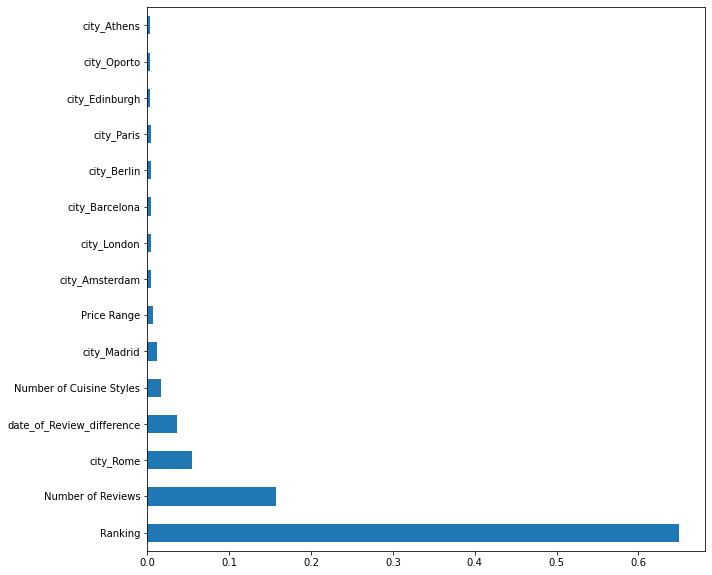

In [59]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [60]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Number of Cuisine Styles,date_of_Review_difference,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,...,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,city_nan
7632,0.084686,1.0,141.0,0.0,6,49.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6262,0.446955,2.0,6.0,0.0,3,189.0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6623,0.544382,2.0,0.0,0.0,1,123.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8980,0.632230,2.0,8.0,0.0,1,123.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
752,0.603342,2.0,12.0,0.0,2,80.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5565,0.103368,1.0,57.0,0.0,6,68.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9872,0.870834,2.0,79.0,0.0,3,11.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1568,0.466932,1.0,88.0,0.0,4,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
937,0.566534,2.0,4.0,0.0,1,123.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3298,0.327920,2.0,25.0,0.0,3,289.0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [61]:
test_data = test_data.drop(['Rating'], axis=1)

In [62]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [63]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [64]:
predict_submission

array([3.02 , 4.36 , 4.445, ..., 3.1  , 4.5  , 4.22 ])

In [65]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.020
1,id_1,4.360
2,id_2,4.445
3,id_3,4.300
4,id_4,4.495
5,id_5,4.455
6,id_6,1.285
7,id_7,3.585
8,id_8,4.185
9,id_9,4.690
